<a href="https://colab.research.google.com/github/bhadreshpsavani/UnderstandingNLP/blob/master/TrainRNNonTimeSeriesForcastingSineSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Create Data

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

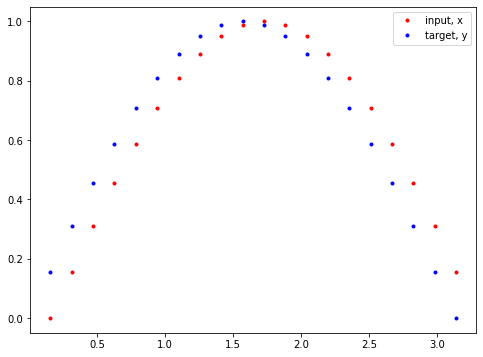

In [2]:
plt.figure(figsize=(8, 6))

# how many time step/datapoint in each bach
seq_len = 20

# generate evenly spaced datapoints
time_steps = np.linspace(0, np.pi, seq_len+1)
data = np.sin(time_steps) 
data.resize((seq_len+1, 1)) # size becomes (seq_len+1, 1) like input dim

x = data[:-1] # all but not last one
y = data[1:] # all but not first one

# display the data
plt.plot(time_steps[1:], x, 'r.', label = 'input, x')
plt.plot(time_steps[1:], y, 'b.', label = 'target, y')

plt.legend(loc='best')
plt.show()

# Create Model

In [3]:
class RNN(nn.Module):
  def __init__(self, input_size, output_size, hidden_dim, n_layers):
    super(RNN, self).__init__()
    self.hidden_dim = hidden_dim

    # batch_first will ensure that first dim of input and output will be batch size
    self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)

    self.fc = nn.Linear(hidden_dim, output_size)

  def forward(self, x, hidden):
    # x (batch_size, seq_len, input_size)
    batch_size = x.size(0)

    # hidden (n_layers, batch_size, hidden_dim)
    # r_out (batch_size, time_step, hidden_dim)
    r_out, hidden = self.rnn(x, hidden)

    # r_out (batch_size* time_step, hidden_dim)
    r_out = r_out.view(-1, self.hidden_dim)

    output = self.fc(r_out)
    return output, hidden

## Check input and out dim

In [4]:
# test rnn dim
test_rnn = RNN(input_size=1, output_size=1, hidden_dim=10, n_layers=2)

time_step = np.linspace(0 , np.pi, seq_len)
data = np.sin(time_step)
data.resize((seq_len, 1))

tensor_input = torch.Tensor(data).unsqueeze(0)
print("Input size:", tensor_input.size())

test_out, test_hidd = test_rnn(tensor_input, None)
print("Output size:", test_out.size())
print("Hidden size:", test_hidd.size())

Input size: torch.Size([1, 20, 1])
Output size: torch.Size([20, 1])
Hidden size: torch.Size([2, 1, 10])


## Train RNN

In [5]:
# Hyperparameter
input_size = 1
output_size = 1
hidden_dim= 32
n_layers = 1

# instantiate RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


## Loss and Optimization

In [6]:
criterian = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)

## Train

In [7]:
def train(rnn, n_steps, print_every):
  hidden = None
  for batch_i, step in enumerate(range(n_steps)):
    time_steps = np.linspace(step*np.pi, (step+1)*np.pi, seq_len+1)
    data = np.sin(time_steps) 
    data.resize((seq_len+1, 1)) # size becomes (seq_len+1, 1) like input dim

    x = data[:-1] # all but not last one
    y = data[1:] # all but not first one

    x_tensor = torch.Tensor(x).unsqueeze(0)
    y_tensor = torch.Tensor(y)

    predict, hidden = rnn(x_tensor, hidden)
    hidden = hidden.data

    loss = criterian(predict, y_tensor)
    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    if batch_i%print_every == 0:
      print("Loss:", loss.item())
      plt.plot(time_steps[1:], x, 'r.')
      plt.plot(time_steps[1:], predict.data.numpy().flatten(), 'b.')
      plt.show()
    
  return rnn

Loss: 0.34285131096839905


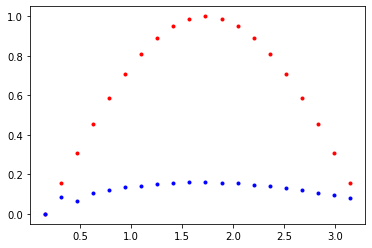

Loss: 0.0033006989397108555


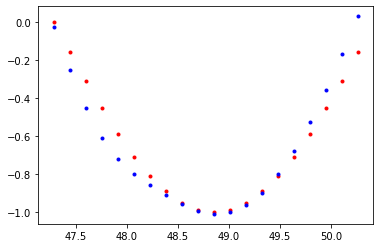

Loss: 0.0005263827042654157


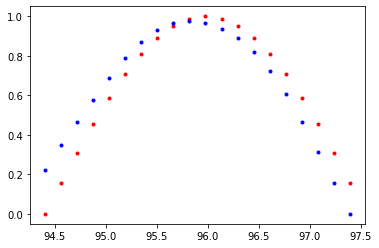

Loss: 0.0002621159073896706


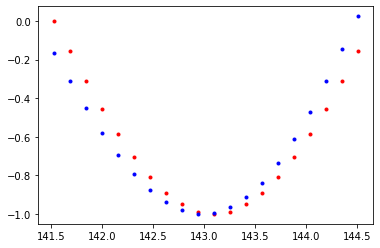

Loss: 0.00022359038121066988


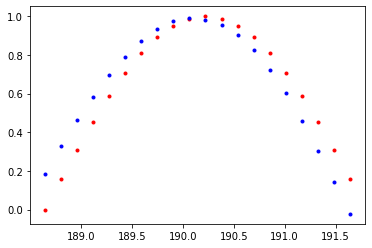

Loss: 0.00022410028032027185


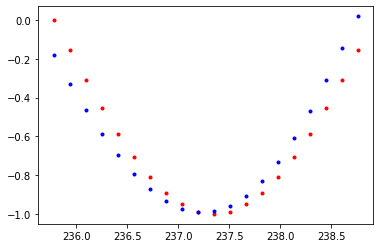

Loss: 0.0002443285775370896


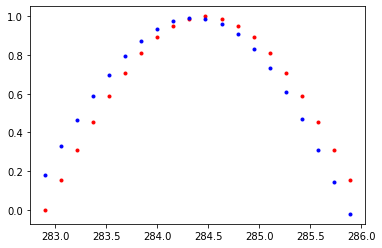

Loss: 0.00026453242753632367


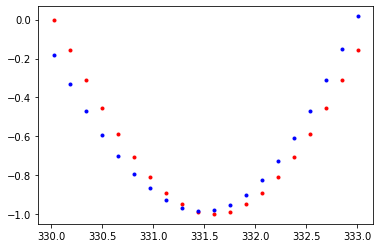

Loss: 0.00029471173183992505


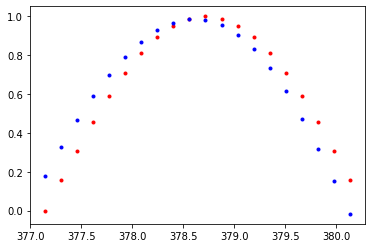

Loss: 0.0002832954633049667


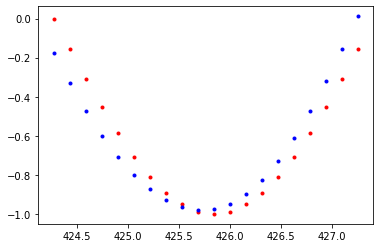

Loss: 0.0002778132038656622


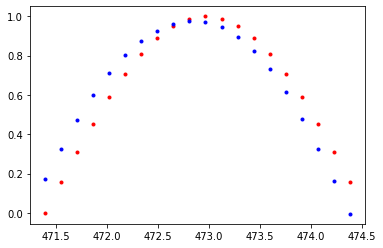

Loss: 9.370709449285641e-05


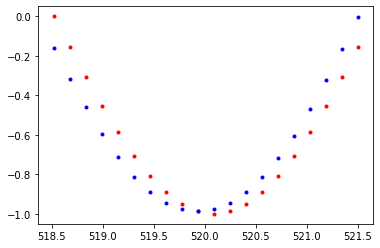

Loss: 1.175389661511872e-05


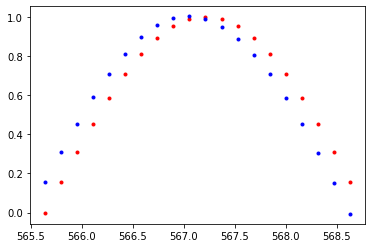

Loss: 1.1073783753090538e-05


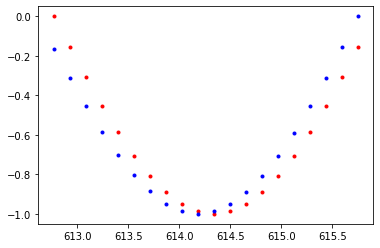

In [8]:
# train
n_steps = 200
print_every = 15
trained_rnn = train(rnn, n_steps, print_every)